
## Семинар 4. Модели экспоненциального сглаживания. Порядок построения и валидации модели.



In [35]:
from sktime.datasets import load_uschange
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np


from sktime.forecasting.all import temporal_train_test_split
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sktime.forecasting.base import ForecastingHorizon

from sktime.datasets import load_macroeconomic, load_airline

from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV

from sktime.utils.plotting import plot_correlations


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)


### Общий алгоритм

Временные ряды отличаются некоторой спецификой. Основной проблемой при работе с такими данными является наличие утечек. На всех этапах работы с временными рядами обращайте внимание на потенциальные места, провоцирующие утечки. Ниже я собрал в одну схему некоторую последовательность действий, которые обычно следует совершить при работе с временными рядами. Разберём его по шагам.

![algorithm](images/sem_4_algorithm.png)


1) Эксплоративный анализ. Подробно об этом мы уже поговорили на предыдущих семинарах и сейчас останавливаться не будем. Основная идея: необходимо заметить как можно больше паттернов в ряде, чтобы проще было подбирать модель или фичи.

2) Разбиение на трейн и тест. Эту часть мы с вами также довольно подробно разобрали. Важные особенности, которые следует держать в голове:

* Тест идёт строго после трейна, иначе будет утечка. 
* Если нормируете или как-либо ещё предобрабатываете данные, делайте это только на трейне. Иначе за счёт информации о тесте в нормировке произойдёт утечка.


3) Помимо привычной вам предобработки из машинного обучения, во временных рядах также часто используются преобразования, сводящие ряд к стационарному. Стационарные ряды нам интересны по вполне очевидной причине: чем меньше меняются характеристики ряда по времени, тем проще его прогнозировать. В контексте ETS-моделей этот вопрос не сильно важен. ETS-модели сами по себе моделируют нестационарные ряды с трендами. Однако в контексте ARMA-моделей это будет ключевым вопросом.

* Сделать ряд стационарным по матожиданию можно всегда. Для этого необходимо просто несколько раз последовательно взять разности от него. Количество раз, необходимых для тренд-стационарности ряда, называется порядком интеграции (Integration order) и обычно обозначается как I(k), где k -- порядок интеграции. Про тестирование ряда на стационарность также поговорим через пару семинаров.

* Со стационарностью по дисперсии всё сложнее. Она бывает сложной формы и не всегда можно подобрать такое преобразование, которое её сгладит. В большинстве случаев это просто игнорируют, либо учитывают уже в самой модели (например, мультипликативная сезонность)

Ниже приведён пример обработки ряда с авиаперевозками. Мы видим, что дисперсия зависит от экспоненциального тренда. Попробуем сгладить её логарифмом.

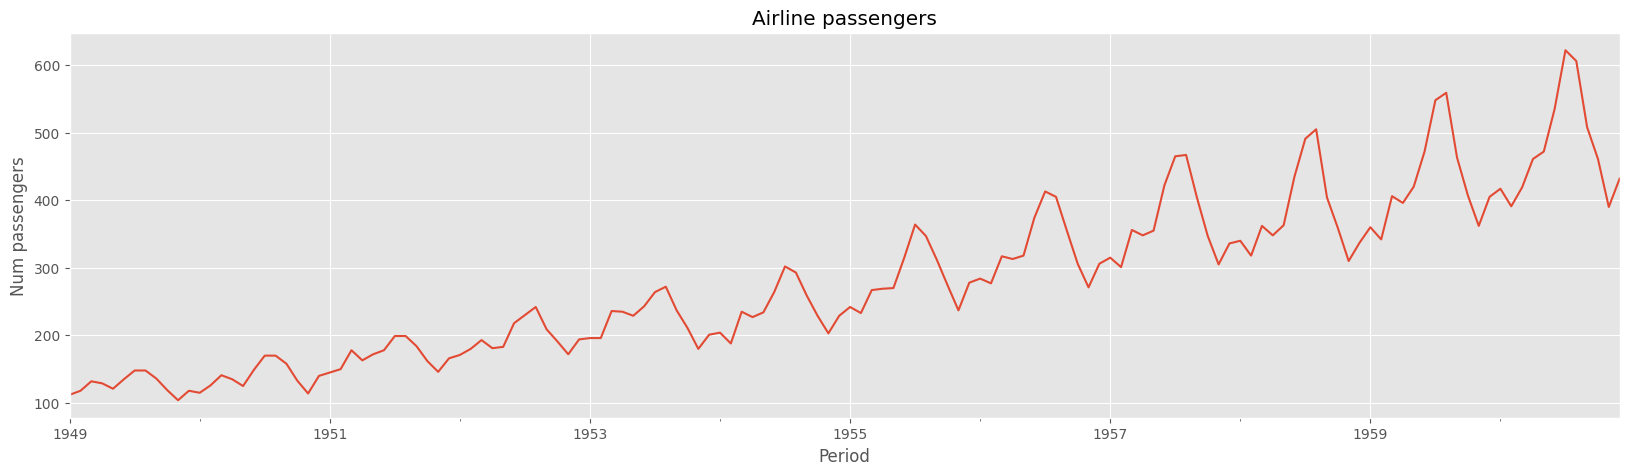

In [66]:


y = load_airline()
y.plot()

plt.title('Airline passengers')
plt.ylabel('Num passengers');


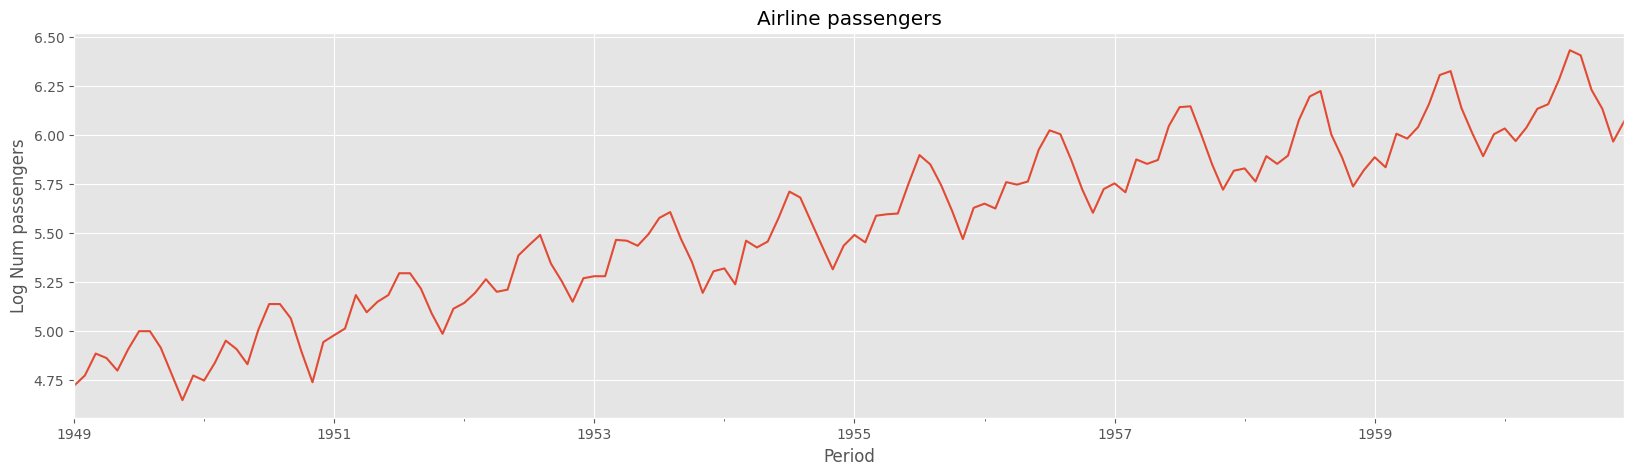

In [67]:

np.log(y).plot()

plt.title('Airline passengers')
plt.ylabel('Log Num passengers');

Преобразование Бокса-Кокса является способом автоматизировать стабилизацию дисперсии. Оно устроено следующим образом:

 $$\frac{y^{\lambda}-1}{\lambda}, \lambda \neq 0 \text { or } \ln (y), \lambda=0$$

Легко показать, что в пределе по $\lambda$ дробь стремится к логарифму. С помощью метода максимального правдоподобия можно найти оценку оптимального параметра  $\lambda$.

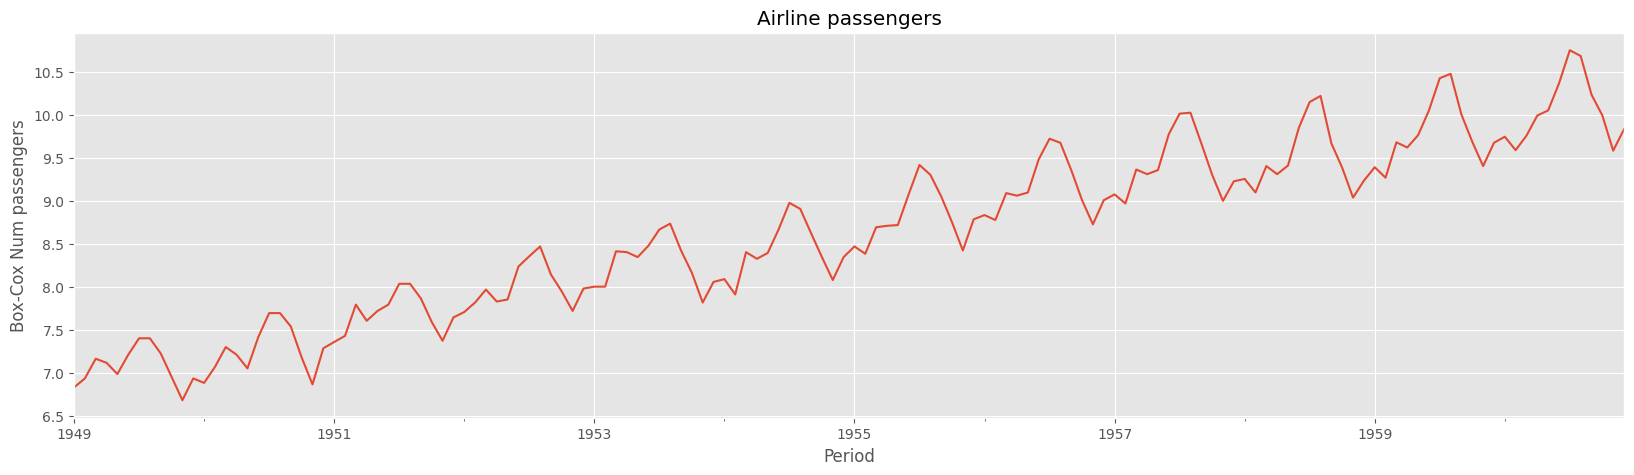

In [68]:
from sktime.transformations.series.boxcox import BoxCoxTransformer

transformer = BoxCoxTransformer()
y_hat = transformer.fit_transform(y)

y_hat.plot()

plt.title('Airline passengers')
plt.ylabel('Box-Cox Num passengers');


In [69]:
transformer.lambda_

0.14802265137037945

Давайте далее возьмём какие-нибудь данные и будем на них сразу практиковаться. У нас будут довольно простые данные, количество игроков в час в одной мобильной онлайн-игре. В наших данных нет особых трендов и монотонных нестационарностей по дисперсии, поэтому преобразовывать ничего не будем. Единственное, что сделаем -- подвинем трейн немного вверх, чтобы мультипликативные модели не сбоили. Далее просто разобьём на трейн и тест.


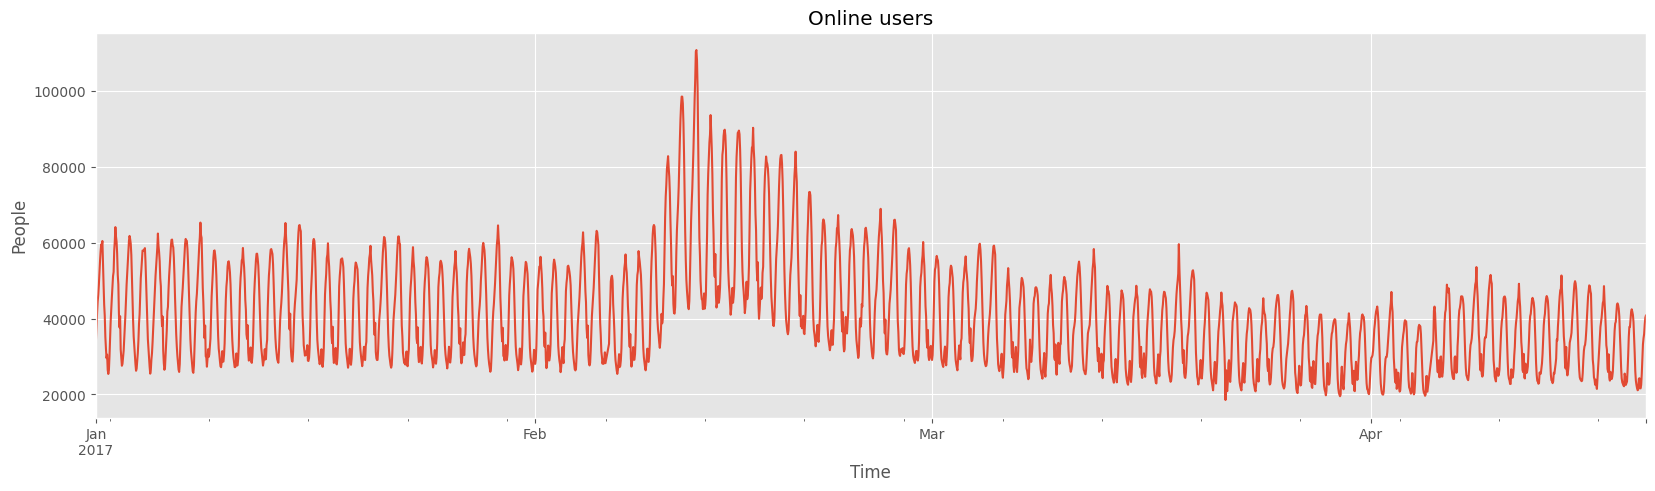

In [148]:
y = pd.read_csv('./data/sem_4/hour_online.csv', index_col=['Time'], parse_dates=['Time']).Users

# Вот этот шаг был неочевиден. С обычным datetime индексом всё ломалось по очевидной недоделке. Думаю, это скоро допилят
y.index = pd.PeriodIndex(y.index, freq="H")
y = y.astype(np.float64)

# Убираем выбросы и интерполируем
y[y<10000] = np.nan
y = y.interpolate()

y_train, y_test = temporal_train_test_split(y, test_size=24)

# y.diff().dropna().plot()
y.plot()
plt.title('Online users')
plt.ylabel('People');

In [105]:
# y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=24)

4) Окей. Мы имеем предобработанные трейн и набор инструкций, чтобы сделать обратные преобразования над прогнозами. Собственно, пора переходить к построению модели. Необходимо выбрать подходящую архитектуру и подобрать на ней гиперпараметры для наилучшего качества прогнозов. Существует ряд автоматических алгоритмов для подбора гиперпараметров. Например, AutoETS и AutoARIMA. Однако большинство из них (за исключением AutoARIMA) представляют из себя обычную кросс-валидацию, зашитую в удобный (или нет) пайплайн.

    На практике обычно руками подобрать модель может быть более эффективно. Например, AutoARIMA я обычно переигрываю при построении на глаз. Поэтому полагаться на них особо не стоит и лучше самостоятельно провести кросс-валидацию. 





5) Допустим вы выбрали самостоятельно делать кросс-валидацию. Для начала следует, полагаясь на здравый смысл и статистические тесты (будет позже), выбрать модели-кандидаты. То есть, построить сетку для кросс-валидации. Посмотрим на данные. Явных трендов почти нет. Значит ограничимся моделями без тренда или с аддитивным трендом. Далее, в районе февраля видим повышение онлайна. Можно заметить, что сезонные колебания в это время были выше. Значит, можно попробовать модели с мультипликативной сезонностью и мультипликативной ошибкой.




In [106]:


fh = ForecastingHorizon(list(range(1, len(y_test)+1)))

forecaster = AutoETS(sp=24)
param_grid = {
    'error': ['add', 'mul'],
    'trend': [None, 'add'],
    'seasonal': ['mul'],
#     'damped_trend': [True, False]
}

6) Наша сетка готова. Но про саму кросс-валидацию мы ещё не говорили. А она имеет свои особенности. Во временных рядах нельзя шаффлить (есть аргументы, что можно, но здесь я ретроград) и нельзя ставить трейн после теста хронологически. Значит, учтём эти ограничения. Всего выделяют два основных метода: расширяющегося окна (Expanding window) и скользящего окна (Sliding window). Вообще их больше, но эти два наиболее часто используются. Об остальных можно почитать, например, в [статье](https://arxiv.org/pdf/1905.11744.pdf).

### Метод скользящего окна

Может быть полезен, если данные сильно нестационарны. Поможет не смещать сильно модель относительно далёких данных

![](images/sem_4_crossval_1.jpg)


### Метод расширяющегося окна

Учитывает максимум данных и будет полезен, когда данные более-менее стационарны

![](images/sem_4_crossval_2.jpg)

### Общая картинка

![](images/sem_4_crossval_3.png)

In [109]:
cv = ExpandingWindowSplitter(
    initial_window=700,
    step_length=100,
    # start_with_window=True,
    fh=fh)
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    n_jobs=-1
    )
gscv.fit(y_train);

In [110]:
gscv.best_params_

{'error': 'mul', 'seasonal': 'mul', 'trend': None}

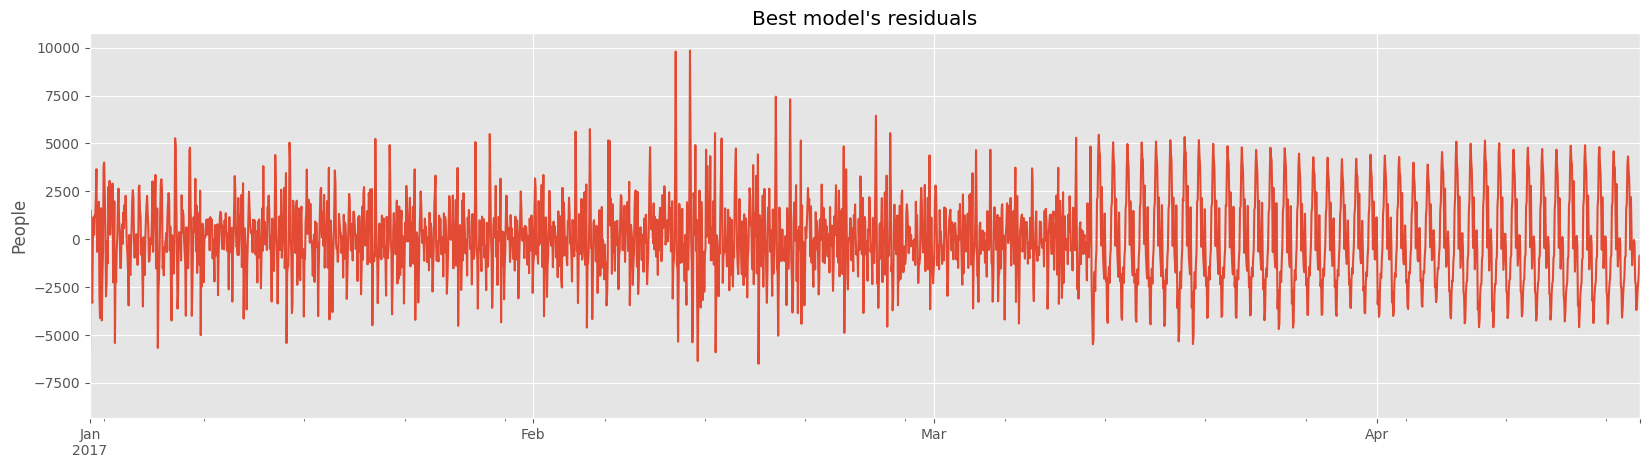

In [146]:
resid = gscv.predict_residuals()

resid.plot()
plt.title('Best model\'s residuals')
plt.ylabel('People');

(<Figure size 1200x800 with 3 Axes>,
 array([<AxesSubplot: >,
        <AxesSubplot: title={'center': 'Autocorrelation'}>,
        <AxesSubplot: title={'center': 'Partial Autocorrelation'}>],
       dtype=object))

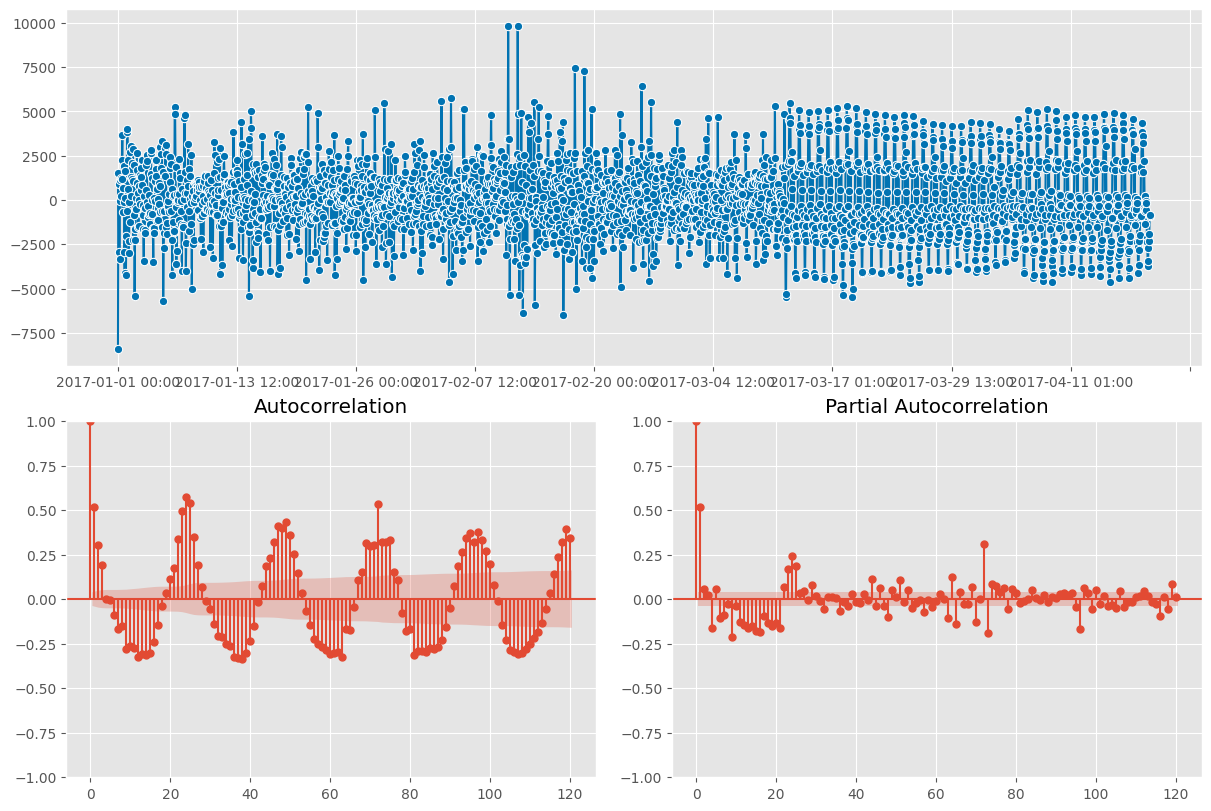

In [147]:
plot_correlations(resid, lags = 24*5)

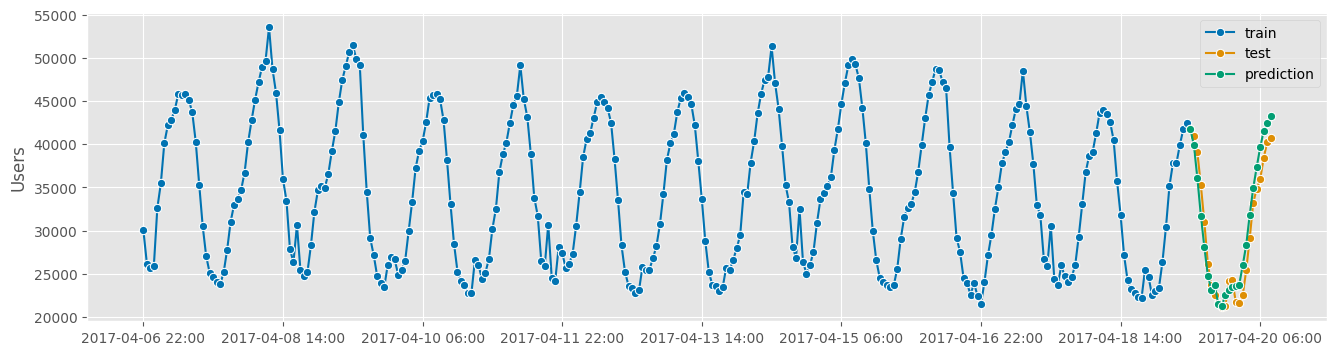

In [113]:
y_pred = gscv.predict(fh)
plot_series(y_train.tail(300), y_test, y_pred,  labels=['train', 'test', 'prediction']);

print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')